In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rd
import sys
import matplotlib.pyplot as plt
import time

In [2]:
rd.seed(777)

dataset_num = 1000
variance = 0.4
wtflag = 0
file_exist = False

# making dataset
def making_data_set(d_num):
    d_set = np.empty(1)
    if file_exist:
        tmp = np.load(sys.argv[1])
        d_set = np.append(d_set, tmp)
    else:
        for i in range(int(d_num)):
            b0 = int(rd.randint(0, 2, 1))
            b1 = int(rd.randint(0, 2, 1))
            b2 = int(rd.randint(0, 2, 1))
            
            x = rd.normal(b0*2 - 1, variance)
            y = rd.normal(b1*2 -1, variance)
            z = rd.normal(b2*2-1, variance)
            
            result = b0 + b1 + b2
            
            rb0 = result % 2
            rb1 = int(result/2) % 2
            d_set = np.append(d_set, [[x, y, z, rb0, rb1]])
            '''x = rd.randint(0, 2, 1)
            y = rd.randint(0, 2, 1)
            rst = x | y
            
            d_set = np.append(d_set, [x, y, rst])'''
    d_set = np.delete(d_set, 0, axis=0)
    d_set = d_set.reshape(-1, 5)
    #d_set = d_set.reshape(-1, 3)
    return d_set
t_data = making_data_set(dataset_num).astype(np.float32)
t_x_data = t_data[:, 0:-2]
t_y_data = t_data[:, -2:].reshape(-1, 2)

test_data = making_data_set(500).astype(np.float32)
test_x_data = test_data[:, 0:-2]
test_y_data = test_data[:, -2:].reshape(-1, 2)

test_y_data.shape

(500, 2)

In [3]:
epochs = 1000
batch = 5
learning_rate = 0.005 #0.6 일 때 cross_entropy의 무한발산 특성 때문에 nan 뜨는경우가 잇엇음 in relu
end_learning_rate = 0.005
result_mean = 0.5

step : 0	 train cost : 0.715	 train accuracy : 0.485	 test cost :0.7116	 test accuracy : 0.486
step : 40	 train cost : 0.6639	 train accuracy : 0.6675	 test cost :0.664	 test accuracy : 0.7
step : 80	 train cost : 0.6113	 train accuracy : 0.7275	 test cost :0.6146	 test accuracy : 0.753
step : 120	 train cost : 0.5607	 train accuracy : 0.75	 test cost :0.5671	 test accuracy : 0.774
step : 160	 train cost : 0.5161	 train accuracy : 0.815	 test cost :0.5248	 test accuracy : 0.816
step : 200	 train cost : 0.4752	 train accuracy : 0.8375	 test cost :0.4861	 test accuracy : 0.835
step : 240	 train cost : 0.4398	 train accuracy : 0.88	 test cost :0.4525	 test accuracy : 0.847
step : 280	 train cost : 0.4098	 train accuracy : 0.9	 test cost :0.4243	 test accuracy : 0.87
step : 320	 train cost : 0.3843	 train accuracy : 0.9325	 test cost :0.4006	 test accuracy : 0.906
step : 360	 train cost : 0.3627	 train accuracy : 0.9375	 test cost :0.3805	 test accuracy : 0.917
step : 400	 train cost : 0.3

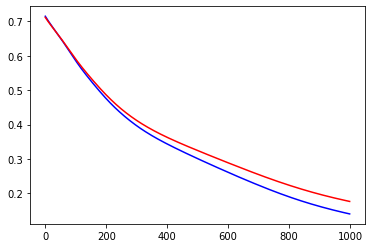

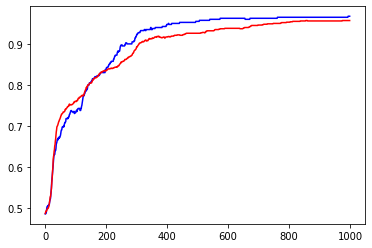

In [5]:
tf.get_seed(777)
tf.reset_default_graph()

input_x = tf.placeholder(tf.float32, [None, 3])
input_y = tf.placeholder(tf.float32, [None, 2])

'''Use tf.Variable, random_normal'''
'''w1 = tf.Variable( tf.random_normal([3, 40]), 'weight1')
bias1 = tf.Variable( tf.random_normal([40]), 'b1')
ouput1 = tf.sigmoid(tf.matmul(input_x, w1) + bias1)

w2 = tf.Variable( tf.random_normal([40, 40]), 'weight2')
bias2 = tf.Variable( tf.random_normal([40]), 'b2')
output2 = tf.sigmoid(tf.matmul(ouput1, w2) + bias2)

w3 = tf.Variable( tf.random_normal([40, 40]), 'weight3')
bias3 = tf.Variable( tf.random_normal([40]), 'b3')
output3 = tf.sigmoid(tf.matmul(output2, w3) + bias3)

w4 = tf.Variable( tf.random_normal([40, 2]), 'weight4')
output4 = tf.sigmoid(tf.matmul(output3, w4))'''

'''use get_variable, xavier_initializer'''
w1 = tf.get_variable( 'weight1', [3, 30], initializer=tf.contrib.layers.xavier_initializer())
bias1 = tf.get_variable( 'b1', [30], initializer=tf.contrib.layers.xavier_initializer())
ouput1 = tf.nn.relu(tf.matmul(input_x, w1) + bias1)

w2 = tf.get_variable( 'weight2', [30, 30], initializer=tf.contrib.layers.xavier_initializer() )
bias2 = tf.get_variable(  'b2', [30], initializer=tf.contrib.layers.xavier_initializer())
output2 = tf.nn.relu(tf.matmul(ouput1, w2) + bias2)

w3 = tf.get_variable(  'weight3', [30, 30],initializer=tf.contrib.layers.xavier_initializer() )
bias3 = tf.get_variable( 'b3', [30],initializer=tf.contrib.layers.xavier_initializer() )
output3 = tf.nn.relu(tf.matmul(output2, w3) + bias3)

w4 = tf.get_variable('weight4', [30, 2] ,initializer=tf.contrib.layers.xavier_initializer() )
#output4 = tf.nn.softmax(tf.matmul(output3, w4))
output4 = tf.sigmoid(tf.matmul(output3, w4))

cost = -tf.reduce_mean(input_y*tf.log(output4) + (1-input_y)*tf.log(1-output4))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
predicted = tf.cast(output4>0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, input_y), dtype=tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = time.time()

train_loss, test_loss, train_accuracy, test_accuracy = [], [], [], []
weight_hist = []
delta_hist = []
bias_hist = []

for step in range(epochs):
    for i in range(batch):
        tmp = int(len(t_x_data)/batch)
        _, cost_val, accuracy_val = sess.run([train, cost, accuracy], \
                                             feed_dict={input_x : t_x_data[i:i+tmp], input_y : t_y_data[i:i+tmp]})
    test_cost_val, test_accuracy_val, output3_val = sess.run([cost, accuracy, output3], feed_dict={input_x : test_x_data, input_y : test_y_data})
    train_loss.append(cost_val); test_loss.append(test_cost_val); train_accuracy.append(accuracy_val); test_accuracy.append(test_accuracy_val)
    if step % 40 == 0:
        print(f"step : {step}\t train cost : {cost_val:.4}\t train accuracy : {accuracy_val:.4}\t test cost :{test_cost_val:.4}\t test accuracy : {test_accuracy_val:.4}") 
    if step == (epochs-1):
        print(output3_val[0])
end_time = time.time()

print(f'time : {end_time-start_time}')

plt.figure()
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')
plt.show()

plt.figure()
plt.plot(train_accuracy, 'b')
plt.plot(test_accuracy, 'r')
plt.show()
